# Model Selection

In [165]:
# Importation des différentes librairies utilisées
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RepeatedStratifiedKFold, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.feature_selection import VarianceThreshold, RFECV, RFE
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve
from sklearn.linear_model import LassoCV
from statsmodels.tools import add_constant
from statsmodels.api import Logit
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import cross_val_predict
import statsmodels.api as sm
from statistics import mean

In [7]:
#on définit les datasets et la variable de prédiction
df = pd.read_csv('data_unscaled.csv', index_col=0)
df_scaled = pd.read_csv('data_scaled.csv', index_col=0)
prediction = 'high_blood_pressure'

#on importe la liste des variables binaires
co_binaires_bis = pd.read_csv('co_binaires_bis', index_col=0)
co_binaires_bis = co_binaires_bis.values.tolist()
co_binaires_bis = sum(co_binaires_bis, [])

## Logistic Regression

In [62]:
X_bis=add_constant(X[co_lasso])

In [65]:
logreg=sm.Logit(y,X_bis )
result=logreg.fit(maxiter=10000)

Optimization terminated successfully.
         Current function value: 0.414591
         Iterations 3088


In [66]:
print(result.summary())

                            Logit Regression Results                           
Dep. Variable:     high_blood_pressure   No. Observations:                 1291
Model:                           Logit   Df Residuals:                     1242
Method:                            MLE   Df Model:                           48
Date:                 Sat, 12 Dec 2020   Pseudo R-squ.:                  0.3302
Time:                         17:41:57   Log-Likelihood:                -535.24
converged:                        True   LL-Null:                       -799.09
Covariance Type:             nonrobust   LLR p-value:                 5.349e-82
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const                            73.0234   1.46e+15   5.01e-14      1.000   -2.86e+15    2.86e+15
overweight                        0.4457      0.177      2.524    

## Feature Selection

Nous allons mettre en place plusieurs méthodes de sélection des caractéristiques afin de les comparer par la suite.

### Méthode Lasso

In [8]:
# Définition du DataSet
X = df_scaled.drop(prediction, axis = 1)
y = df_scaled[prediction]

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3, stratify = y)

In [71]:
# On utilise le lasso pour choisir les features les plus intéressantes
def make_lasso(dataframe, alpha = 1):
    df2 = dataframe.select_dtypes(include=np.number)
    yindex = df2.columns.get_loc(prediction)
    lasso1 = Lasso(fit_intercept=False,normalize=False, alpha = alpha)
    lasso1.fit(X,y)
    return lasso1, data, yindex

my_alphas = np.arange(0.001,1,0.001)
lcv = LassoCV(alphas=my_alphas ,normalize=False,fit_intercept=False,random_state=0,cv=5).fit(X, y)
lcv.alpha_

0.005

In [104]:
# On crée une liste avec le noms des features les plus intéressants
lasso3,data,yindex = make_lasso(df_scaled, alpha = lcv.alpha_)
features_select_lasso=list(df_scaled.select_dtypes(include=np.number).drop(prediction, axis = 1).columns[np.abs(lasso3.coef_)>0])

In [105]:
# Définition du nouveau dataset
co_binaires_lasso = []
co_continues_lasso = []
for co in features_select_lasso:
    if co in co_binaires_bis:
        co_binaires_lasso.append(co)
    else :
        co_continues_lasso.append(co)
        
X_lasso=X[features_select_lasso]
X_train_lasso = X_train[features_select_lasso]
X_test_lasso = X_test[features_select_lasso]

In [106]:
len(features_select_lasso)

48

### Méthode Variance

In [101]:
# Définition du selector avec la méthode de la variance (supprimer toutes les caractéristiques dont la variance n'atteint pas le seuil choisi)
selector = VarianceThreshold(threshold = 0.15)

selector.fit_transform(X)
features_select_var = list(np.array(list(X))[selector.get_support()])

X_var=X[features_select_var]
X_train_var = X_train[features_select_var]
X_test_var = X_test[features_select_var]

co_binaires_var = []
co_continues_var = []
for co in features_select_var:
    if co in co_binaires_bis:
        co_binaires_var.append(co)
    else :
        co_continues_var.append(co)

In [102]:
len(features_select_var)

70

### Méthode RFECV

Optimal number of features : 10


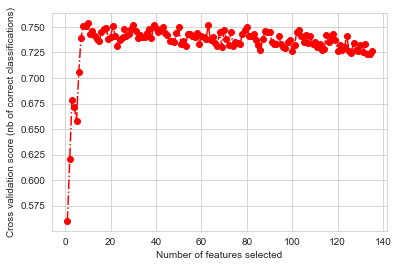

In [96]:
# Définition du selector et graphique donnant le score en fonction du nombre de features 
rfecv = RFECV(estimator=RandomForestClassifier(), step=1, cv=5,
              scoring='f1_weighted')
rfecv.fit(X, y)
features_select_rfe = list(np.array(list(X))[rfecv.get_support()])
print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_, 'or-.')
plt.show()

In [100]:
# Définiton du nouveau dataset
co_binaires_rfe = []
co_continues_rfe = []
for co in features_select_rfe:
    if co in co_binaires_bis:
        co_binaires_rfe.append(co)
    else :
        co_continues_rfe.append(co)

X_rfe=X[features_select_rfe]

X_train_rfe = X_train[features_select_rfe]
X_test_rfe = X_test[features_select_rfe]

## Model Selection

In [129]:
# Définiton des dictionnaires des hyperparamètres
dico_param_tree = {'decisiontreeclassifier__criterion':['gini','entropy'],
         'decisiontreeclassifier__splitter' : ['best', 'random']}
dico_param_rf={"randomforestclassifier__n_estimators":np.arange(10,100,20),
              "randomforestclassifier__criterion":['gini','entropy'],
              "randomforestclassifier__max_features":['auto', 'sqrt', 'log2'],
              "randomforestclassifier__random_state":[None, 0, 42],
              "randomforestclassifier__class_weight" :[None, 'balanced']}
dico_param_log = {'logisticregression__solver' : ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']}
dico_param_mlp = {'mlpclassifier__activation' : ['identity', 'logistic', 'tanh', 'relu'], 
                 'mlpclassifier__solver' : ['lbfgs','sgd', 'adam']}

model_rf = make_pipeline(RandomForestClassifier())
model_tree = make_pipeline(DecisionTreeClassifier())
model_log = make_pipeline(LogisticRegression(max_iter=10000))
model_mlp = make_pipeline(MLPClassifier(max_iter=10000))

In [114]:
# On recherche les meilleurs paramètres
scoring_choice = 'f1_weighted' # on veut que 'recall' et 'precision' importent

# Définition d'une fonction donnant les meilleurs paramètres
def best_param(X, y, pipeline, dico_param, co_continues):
    grid = GridSearchCV(
        pipeline, 
        param_grid = dico_param,  
        cv=5, 
        refit=True, # à la fin, il sélectionne le meilleur jeu d'hyperparamètres et réentraîne le modèle sur toutes les données
        scoring=scoring_choice)
    grid.fit(X, y)
    print(f"Best estimator has {scoring_choice}={round(grid.best_score_, 2)}")
    best_model = grid.best_estimator_
    return best_model

### Pour RandomForest

In [115]:
# Recherche des meilleurs paramètres pour RandomForest pour lasso
best_model_rf_lasso = best_param(X_lasso, y, model_rf, dico_param_rf, co_continues_lasso)

Best estimator has f1_weighted=0.75


In [117]:
# Recherche des meilleurs paramètres pour RandomForest pour Var
best_model_rf_var = best_param(X_var, y, model_rf, dico_param_rf, co_continues_var)

Best estimator has f1_weighted=0.75


In [118]:
# Recherche des meilleurs paramètres pour RandomForest pour RFECV
best_model_rf_rfe = best_param(X_rfe, y, model_rf, dico_param_rf, co_continues_rfe)

Best estimator has f1_weighted=0.75


In [199]:
best_model_rf_lasso = best_model_rf_lasso[0]
best_model_rf_var = best_model_rf_var[0]
best_model_rf_rfe = best_model_rf_rfe[0]

### Pour Decision Tree

In [120]:
# Recherche des meilleurs paramètres pour DecisionTree pour lasso
best_model_tree_lasso = best_param(X_lasso, y, model_tree, dico_param_tree, co_continues_lasso)

Best estimator has f1_weighted=0.71


In [121]:
# Recherche des meilleurs paramètres pour DecisionTree pour Var
best_model_tree_var = best_param(X_var, y, model_tree, dico_param_tree, co_continues_var)

Best estimator has f1_weighted=0.7


In [122]:
# Recherche des meilleurs paramètres pour DecisionTree pour RFECV
best_model_tree_rfe = best_param(X_rfe, y, model_tree, dico_param_tree, co_continues_rfe)

Best estimator has f1_weighted=0.69


In [197]:
best_model_tree_lasso = best_model_tree_lasso[0]
best_model_tree_var = best_model_tree_var[0]
best_model_tree_rfe = best_model_tree_rfe[0]

### Pour Logistic Regression

In [124]:
# Recherche des meilleurs paramètres pour LogisticRegression pour lasso
best_model_log_lasso = best_param(X_lasso, y, model_log, dico_param_log, co_continues_lasso)

Best estimator has f1_weighted=0.77


In [125]:
# Recherche des meilleurs paramètres pour LogisticRegression pour Var
best_model_log_var = best_param(X_var, y, model_log, dico_param_log, co_continues_var)

Best estimator has f1_weighted=0.77


In [126]:
# Recherche des meilleurs paramètres pour LogisticRegression pour RFECV
best_model_log_rfe = best_param(X_rfe, y, model_log, dico_param_log, co_continues_rfe)

Best estimator has f1_weighted=0.77


In [200]:
best_model_log_lasso = best_model_log_lasso[0]
best_model_log_var = best_model_log_var[0]
best_model_log_rfe = best_model_log_rfe[0]

### Résultats selon la sélection de variables par modèle

In [217]:
# Définition d'une fonction pour entraîner un modèle
def fit(X,X_test, y, co_continues, model):
    accuracy = mean(cross_val_score(model, X, y, cv=StratifiedKFold(), scoring='accuracy'))
    auc = mean(cross_val_score(model, X, y, cv=StratifiedKFold(), scoring='roc_auc'))
    precision = mean(cross_val_score(model, X, y, cv=StratifiedKFold(), scoring='precision'))
    f1_weighted = mean(cross_val_score(model, X, y, cv=StratifiedKFold(), scoring='f1_weighted'))
    proba = model.predict_proba(X_test)[:,1]
    
    print('The f1_weighted score pour le modèle : {:.3g}'.format(f1_weighted))
    print('Pourcentage de bien classés pour le modèle : {:.3g}'.format(accuracy))
    print('Aire sous la courbe ROC pour le modèle : {:.3g}'.format(auc))
    print('La précision pour le modèle : {:.3g}'.format(precision))
    return accuracy, auc, precision, f1_weighted, proba

In [191]:
# Définition d'une fonction qui renvoie les meilleures features par rapport à la variance
def best_features(model, X_train, threshold) :     
    features_importances = []
    index_best_features = []
    list_results = model.feature_importances_.tolist()
    best_features = []
    for i in range(len(list_results)):
        if list_results[i] > threshold :
            index_best_features.append(i)
            features_importances.append(list_results[i])
            best_features.append(X_train.columns[i])
    return best_features, features_importances

The f1_weighted score pour le modèle : 0.751
Pourcentage de bien classés pour le modèle : 0.771
Aire sous la courbe ROC pour le modèle : 0.83
La précision pour le modèle : 0.722


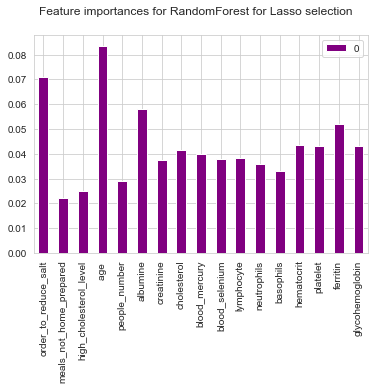

In [219]:
# Modèle RandomForest avec la sélection lasso
accuracy_rf_lasso, auc_rf_lasso, precision_rf_lasso, f1_weighted_rf_lasso, proba_rf_lasso = fit(X_lasso,X_test_lasso, y, co_continues_lasso, best_model_rf_lasso)

best_features_rf_lasso, features_importance_rf_lasso = best_features(best_model_rf_lasso, X_train_lasso, 0.02)

pd.DataFrame(features_importance_rf_lasso, index = best_features_rf_lasso).plot.bar(color='purple')
plt.suptitle('Feature importances for RandomForest for Lasso selection')
plt.legend()

The f1_weighted score pour le modèle : 0.754
Pourcentage de bien classés pour le modèle : 0.773
Aire sous la courbe ROC pour le modèle : 0.818
La précision pour le modèle : 0.727


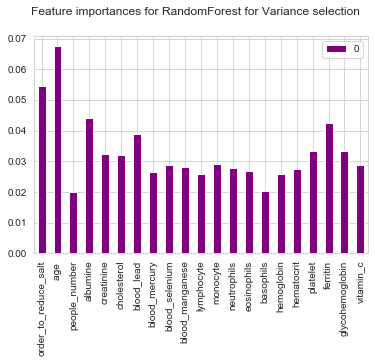

In [222]:
# Modèle RandomForest avec la sélection Var
accuracy_rf_var, auc_rf_var, precision_rf_var, f1_weighted_rf_var, proba_rf_var = fit(X_var, X_test_var,y, co_continues_var, best_model_rf_var)

best_features_rf_var, features_importance_rf_var = best_features(best_model_rf_var, X_train_var, 0.02)

pd.DataFrame(features_importance_rf_var, index = best_features_rf_var).plot.bar(color='purple')
plt.suptitle('Feature importances for RandomForest for Variance selection')
plt.legend()

The f1_weighted score pour le modèle : 0.737
Pourcentage de bien classés pour le modèle : 0.757
Aire sous la courbe ROC pour le modèle : 0.798
La précision pour le modèle : 0.628


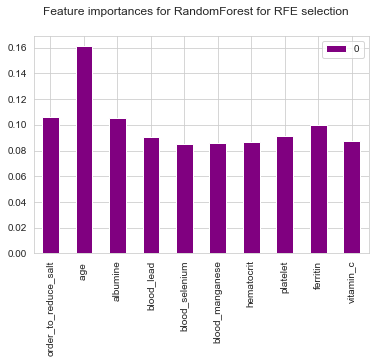

In [223]:
# Modèle RandomForest avec la sélection RFE
accuracy_rf_rfe, auc_rf_rfe, precision_rf_rfe, f1_weighted_rf_rfe, proba_rf_rfe = fit(X_rfe, X_test_rfe, y, co_continues_rfe, best_model_rf_rfe)

best_features_rf_rfe, features_importance_rf_rfe = best_features(best_model_rf_rfe, X_train_rfe, 0.02)

pd.DataFrame(features_importance_rf_rfe, index = best_features_rf_rfe).plot.bar(color='purple')
plt.suptitle('Feature importances for RandomForest for RFE selection')
plt.legend()

The f1_weighted score pour le modèle : 0.694
Pourcentage de bien classés pour le modèle : 0.704
Aire sous la courbe ROC pour le modèle : 0.637
La précision pour le modèle : 0.465


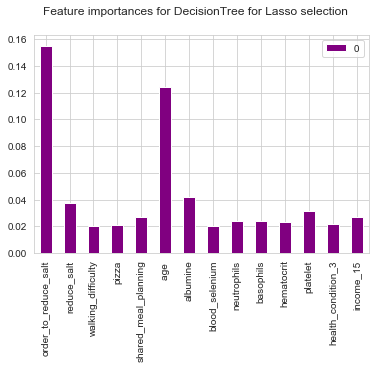

In [278]:
# Modèle DecisionTree avec la sélection lasso
accuracy_tree_lasso, auc_tree_lasso, precision_tree_lasso, f1_weighted_tree_lasso, proba_tree_lasso = fit(X_lasso, X_test_lasso, y, co_continues_lasso, best_model_tree_lasso)

best_features_tree_lasso, features_importance_tree_lasso = best_features(best_model_tree_lasso, X_train_lasso, 0.02)

pd.DataFrame(features_importance_tree_lasso, index = best_features_tree_lasso).plot.bar(color='purple')
plt.suptitle('Feature importances for DecisionTree for Lasso selection')
plt.legend()

The f1_weighted score pour le modèle : 0.701
Pourcentage de bien classés pour le modèle : 0.695
Aire sous la courbe ROC pour le modèle : 0.652
La précision pour le modèle : 0.521


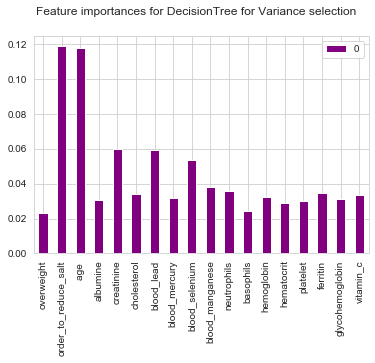

In [225]:
# Modèle DecisionTree avec la sélection Var
accuracy_tree_var, auc_tree_var, precision_tree_var, f1_weighted_tree_var, proba_tree_var = fit(X_var, X_test_var, y, co_continues_var, best_model_tree_var)

best_features_tree_var, features_importance_tree_var = best_features(best_model_tree_var, X_train_var, 0.02)

pd.DataFrame(features_importance_tree_var, index = best_features_tree_var).plot.bar(color='purple')
plt.suptitle('Feature importances for DecisionTree for Variance selection')
plt.legend()

The f1_weighted score pour le modèle : 0.693
Pourcentage de bien classés pour le modèle : 0.687
Aire sous la courbe ROC pour le modèle : 0.639
La précision pour le modèle : 0.489


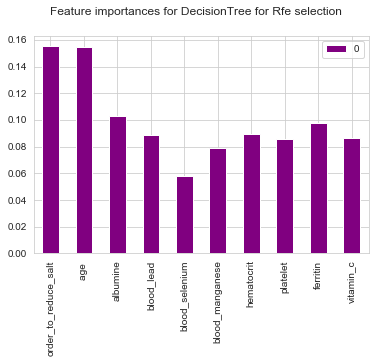

In [226]:
# Modèle DecisionTree avec la sélection Rfe
accuracy_tree_rfe, auc_tree_rfe, precision_tree_rfe, f1_weighted_tree_rfe, proba_tree_rfe = fit(X_rfe, X_test_rfe, y, co_continues_rfe, best_model_tree_rfe)

best_features_tree_rfe, features_importance_tree_rfe = best_features(best_model_tree_rfe, X_train_rfe, 0.02)

pd.DataFrame(features_importance_tree_rfe, index = best_features_tree_rfe).plot.bar(color='purple')
plt.suptitle('Feature importances for DecisionTree for Rfe selection')
plt.legend()

In [227]:
# Modèle LogisticRegression avec la sélection lasso
accuracy_log_lasso, auc_log_lasso, precision_log_lasso, f1_weighted_log_lasso, proba_log_lasso = fit(X_lasso, X_test_lasso, y, co_continues_lasso, best_model_log_lasso)

The f1_weighted score pour le modèle : 0.775
Pourcentage de bien classés pour le modèle : 0.783
Aire sous la courbe ROC pour le modèle : 0.835
La précision pour le modèle : 0.691


In [235]:
# Modèle LogisticRegression avec la sélection Var
accuracy_log_var, auc_log_var, precision_log_var, f1_weighted_log_var, proba_log_var = fit(X_var, X_test_var, y, co_continues_var, best_model_log_var)

The f1_weighted score pour le modèle : 0.769
Pourcentage de bien classés pour le modèle : 0.777
Aire sous la courbe ROC pour le modèle : 0.821
La précision pour le modèle : 0.676


In [228]:
# Modèle LogisticRegression avec la sélection rfe
accuracy_log_rfe, auc_log_rfe, precision_log_rfe, f1_weighted_log_rfe, proba_log_rfe =fit(X_rfe, X_test_rfe, y, co_continues_rfe, best_model_log_rfe)

The f1_weighted score pour le modèle : 0.772
Pourcentage de bien classés pour le modèle : 0.785
Aire sous la courbe ROC pour le modèle : 0.818
La précision pour le modèle : 0.723


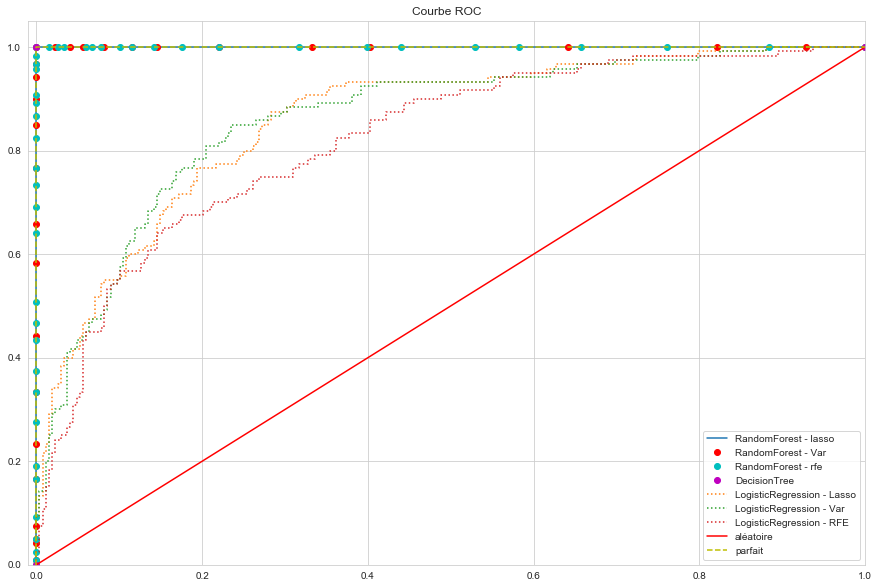

In [274]:
# Courbe ROC
plt.figure(1,figsize=(15,10))
# cas du modèle RandomForest
fpr, tpr, _ = roc_curve(y_test, proba_rf_lasso)
plt.plot(fpr,tpr,"-", label="RandomForest - lasso")

fpr, tpr, _ = roc_curve(y_test, proba_rf_var)
plt.plot(fpr,tpr,"ro", label="RandomForest - Var")

fpr, tpr, _ = roc_curve(y_test, proba_rf_rfe)
plt.plot(fpr,tpr,"co", label="RandomForest - rfe")

# cas du modèle DecisionTree
fpr, tpr, _ = roc_curve(y_test, proba_tree_var)
plt.plot(fpr,tpr,"mo", label="DecisionTree")

# cas du modèle LogisticRegression
fpr, tpr, _ = roc_curve(y_test, proba_log_lasso)
plt.plot(fpr,tpr,":", label="LogisticRegression - Lasso")

fpr, tpr, _ = roc_curve(y_test, proba_log_var)
plt.plot(fpr,tpr,":", label="LogisticRegression - Var")

fpr, tpr, _ = roc_curve(y_test, proba_log_rfe)
plt.plot(fpr,tpr,":", label="LogisticRegression - RFE")

# modèle aléatoire
plt.plot([0, 1], [0, 1],"r-", label="aléatoire", )

# modèle parfait
plt.plot([0,0, 1], [0,1, 1], 'y--', label="parfait")

plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.05])
plt.title('Courbe ROC')
plt.legend()

### Graphique montrant les différentes sélections pour chaque modèle


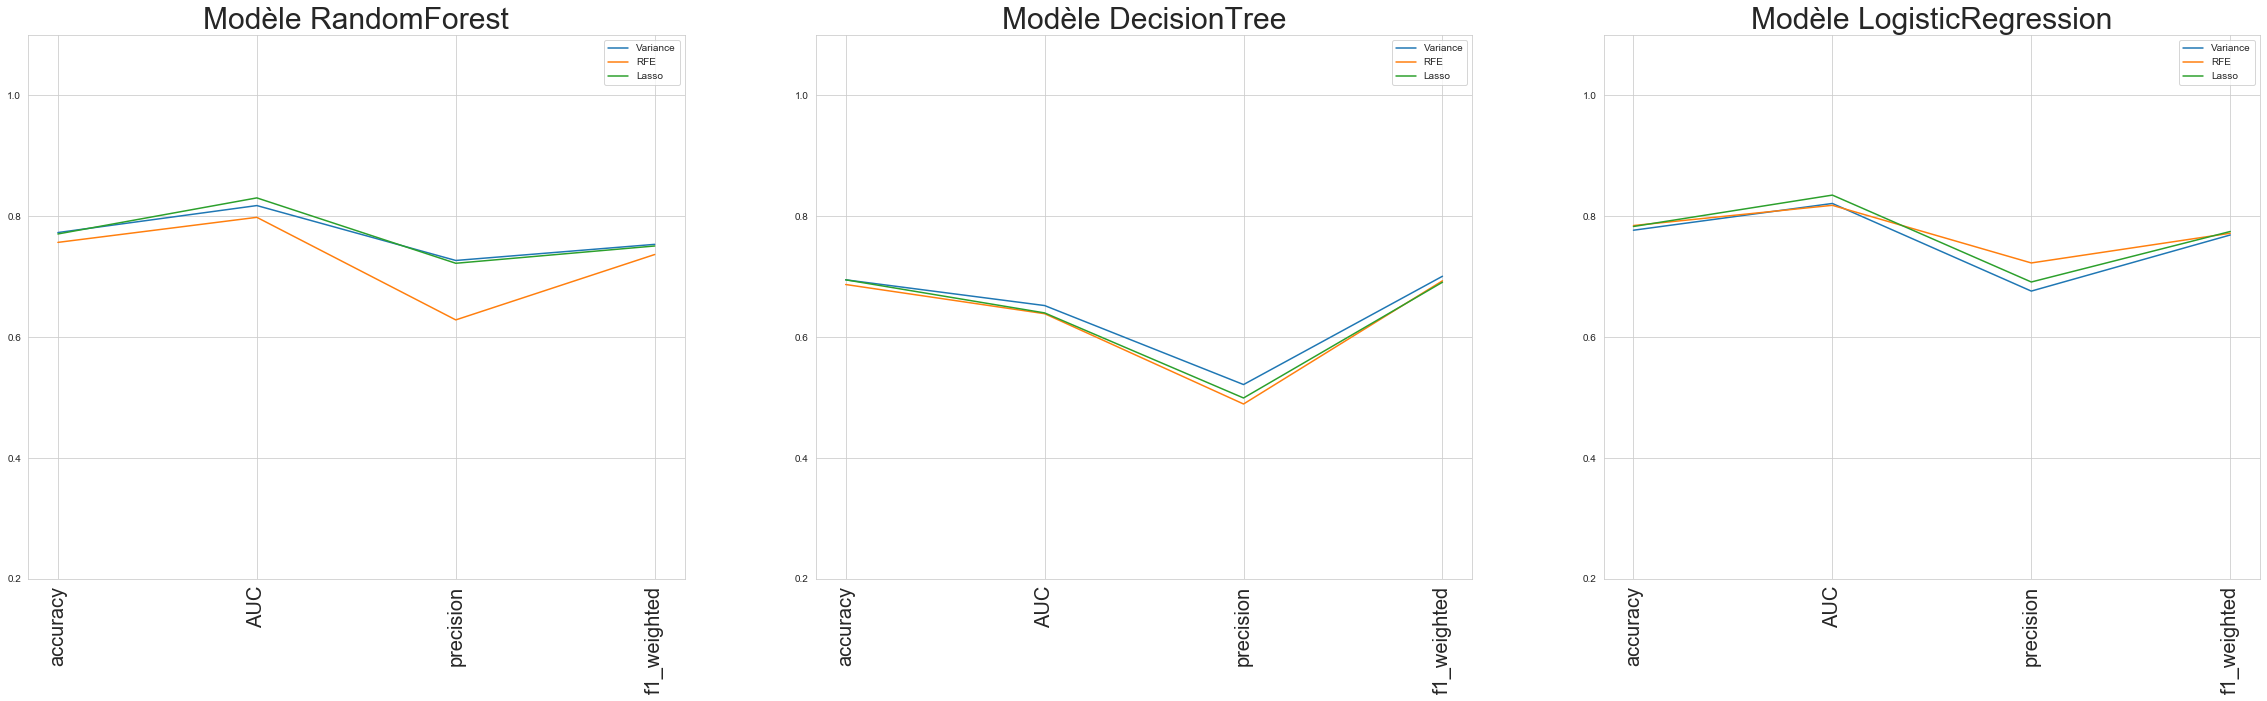

In [262]:
# Graphiques de résumé
X = ['accuracy', 'AUC', 'precision', 'f1_weighted']

Y_rf_lasso = [accuracy_rf_lasso, auc_rf_lasso, precision_rf_lasso, f1_weighted_rf_lasso]
Y_rf_var = [accuracy_rf_var, auc_rf_var, precision_rf_var, f1_weighted_rf_var]
Y_rf_rfe = [accuracy_rf_rfe, auc_rf_rfe, precision_rf_rfe, f1_weighted_rf_rfe]

Y_tree_lasso = [accuracy_tree_lasso, auc_tree_lasso, precision_tree_lasso, f1_weighted_tree_lasso]
Y_tree_var = [accuracy_tree_var, auc_tree_var, precision_tree_var, f1_weighted_tree_var]
Y_tree_rfe = [accuracy_tree_rfe, auc_tree_rfe, precision_tree_rfe, f1_weighted_tree_rfe]

Y_log_lasso = [accuracy_log_lasso, auc_log_lasso, precision_log_lasso, f1_weighted_log_lasso]
Y_log_var = [accuracy_log_var, auc_log_var, precision_log_var, f1_weighted_log_var]
Y_log_rfe = [accuracy_log_rfe, auc_log_rfe, precision_log_rfe, f1_weighted_log_rfe]

plt.figure(1,figsize=(40,10))
plt.subplot(1,3,1)
plt.plot(X,Y_rf_var, label='Variance')
plt.plot(X,Y_rf_rfe, label='RFE')
plt.plot(X,Y_rf_lasso, label='Lasso')
plt.gca().get_xaxis().set_ticklabels(X, fontsize = 20, rotation = 90)
plt.ylim(0.2,1.1)
plt.title('Modèle RandomForest', fontsize=30)
plt.legend()

plt.subplot(1,3,2)
plt.plot(X,Y_tree_var, label='Variance')
plt.plot(X,Y_tree_rfe, label='RFE')
plt.plot(X,Y_tree_lasso, label='Lasso')
plt.gca().get_xaxis().set_ticklabels(X, fontsize = 20, rotation = 90)
plt.ylim(0.2,1.1)
plt.title('Modèle DecisionTree', fontsize=30)
plt.legend()

plt.subplot(1,3,3)
plt.plot(X,Y_log_var, label='Variance')
plt.plot(X,Y_log_rfe, label='RFE')
plt.plot(X,Y_log_lasso, label='Lasso')
plt.gca().get_xaxis().set_ticklabels(X, fontsize = 20, rotation = 90)
plt.ylim(0.2,1.1)
plt.title('Modèle LogisticRegression', fontsize=30)
plt.legend()



## Conclusion de la modélisation

In [263]:
# Définition d'une fonction pour changer les listes en dictionnaire
def change_in_dict(best_features, features_importance):
    dict_best_features = dict()
    for i in range(len(best_features)):
        dict_best_features[best_features[i]] = int(features_importance[i]*100)/100
    return dict_best_features

In [264]:
# Définition des dictionnaires
dict_best_features_rf_var=change_in_dict(best_features_rf_var, features_importance_rf_var)
dict_best_features_rf_rfe=change_in_dict(best_features_rf_rfe, features_importance_rf_rfe)
dict_best_features_rf_lasso=change_in_dict(best_features_rf_lasso, features_importance_rf_lasso)

dict_best_features_tree_var=change_in_dict(best_features_tree_var, features_importance_tree_var)
dict_best_features_tree_rfe=change_in_dict(best_features_tree_rfe, features_importance_tree_rfe)
dict_best_features_tree_lasso=change_in_dict(best_features_tree_lasso, features_importance_tree_lasso)

In [265]:
# Définition du dictionnaire commun donnant les meilleures features
dict_best_features = dict()
dict_best= [dict_best_features_rf_var, dict_best_features_rf_rfe, dict_best_features_rf_lasso ,dict_best_features_tree_var, dict_best_features_tree_rfe, dict_best_features_tree_lasso]
for dictio in dict_best : 
    for nom, valeur in dictio.items():
        if nom not in dict_best_features:
            dict_best_features[nom] = [valeur]
        else:
            dict_best_features[nom].append(valeur)

In [266]:
# On calcule la moyenne de l'importance de chaque feature
for nom, valeur in dict_best_features.items():
    dict_best_features[nom]=int(sum(valeur)/len(valeur)*100)/100

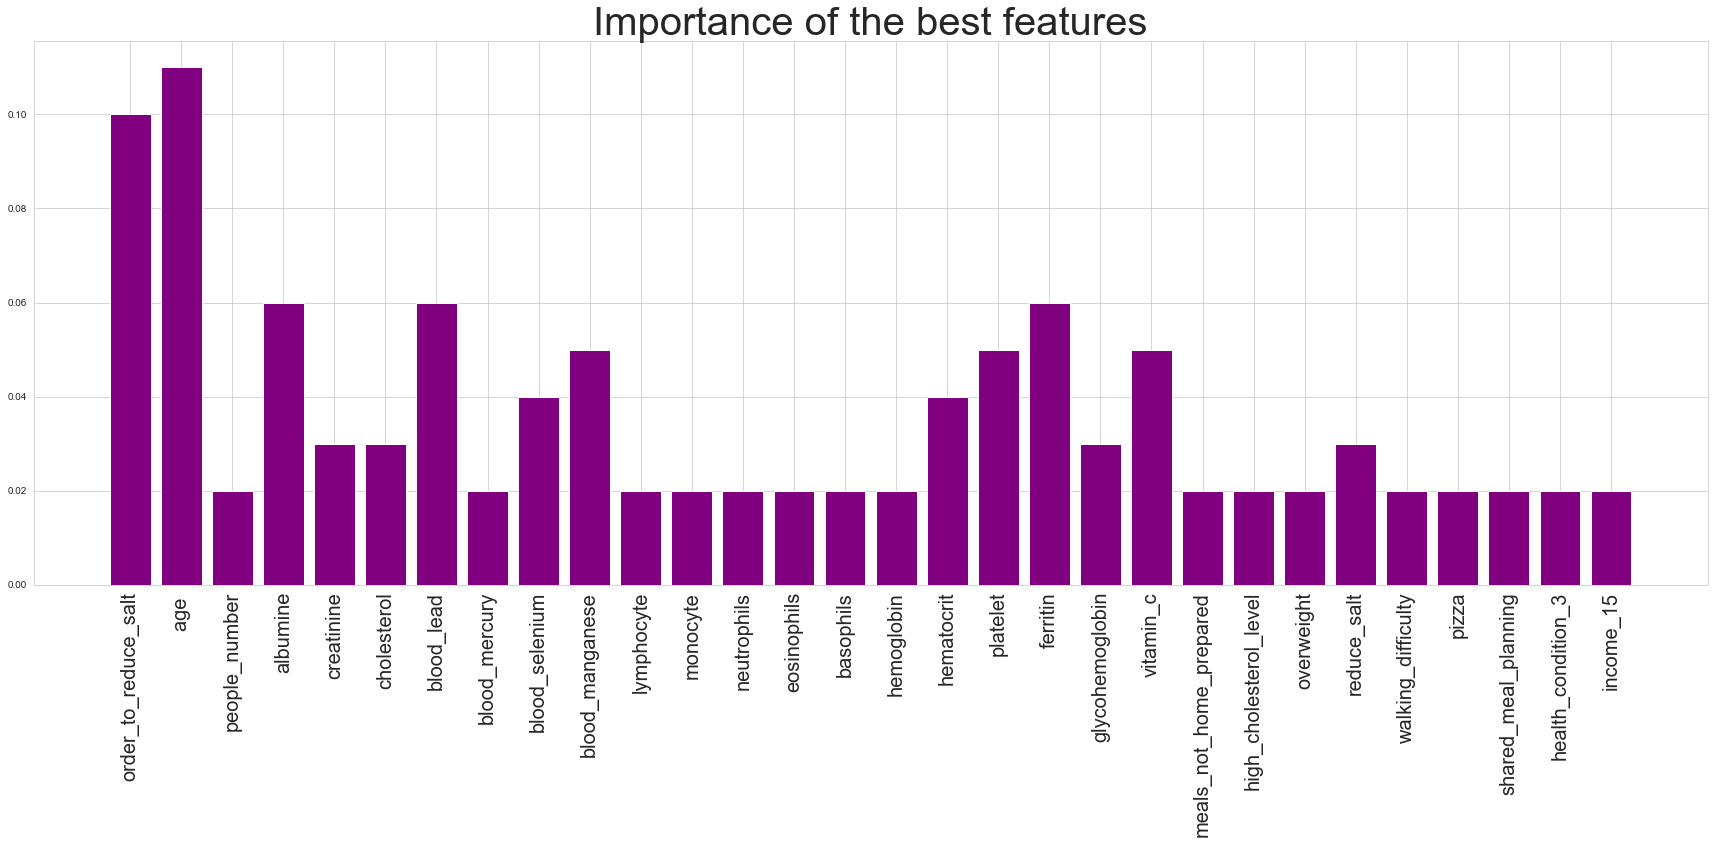

In [270]:
# Graphique montrant l'importance des meilleures features
plt.figure(1, figsize=(30,10))
plt.bar(dict_best_features.keys(), dict_best_features.values(), color='purple')
plt.gca().get_xaxis().set_ticklabels(dict_best_features.keys(), fontsize = 20, rotation = 90)
plt.title('Importance of the best features', fontsize=40)
plt.show()

RandomForest - F1_weighted: 0.75 (+/- 0.04)
DecisionTree - F1_weighted: 0.69 (+/- 0.04)
LogisticRegression - F1_weighted: 0.77 (+/- 0.05)


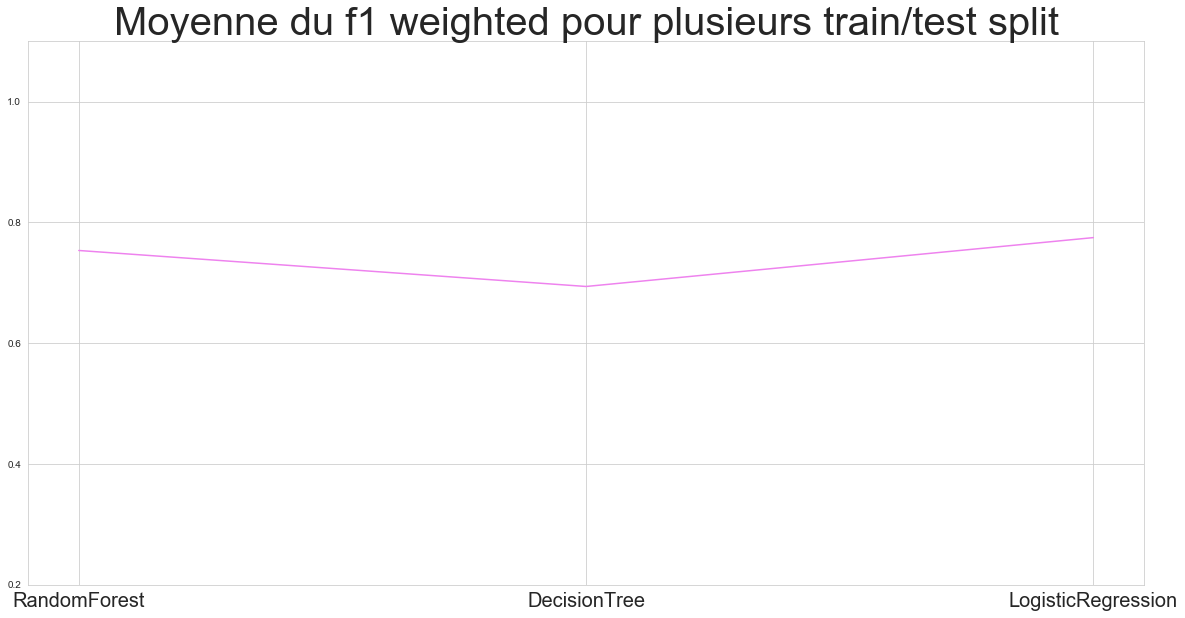

In [291]:
# Moyenne du f1_score pour plusieurs train/test split 
score_rf = cross_val_score(best_model_rf_var, X_var, y, cv=StratifiedKFold(), scoring='f1_weighted')
score_tree = cross_val_score(best_model_tree_var, X_var, y, cv=StratifiedKFold(), scoring='f1_weighted')
score_log = cross_val_score(best_model_log_lasso, X_lasso, y, cv=StratifiedKFold(), scoring='f1_weighted')

print("RandomForest - F1_weighted: %0.2f (+/- %0.2f)" % (score_rf.mean(), score_rf.std() * 2))
print("DecisionTree - F1_weighted: %0.2f (+/- %0.2f)" % (score_tree.mean(), score_tree.std() * 2))
print("LogisticRegression - F1_weighted: %0.2f (+/- %0.2f)" % (score_log.mean(), score_log.std() * 2))


X = ['RandomForest', 'DecisionTree', 'LogisticRegression']
Y = [score_rf.mean(), score_tree.mean(), score_log.mean()]
plt.figure(1,figsize=(20,10))
plt.plot(X,Y, color='violet')
plt.gca().get_xaxis().set_ticklabels(X, fontsize = 20, rotation = 0)
plt.ylim(0.2,1.1)
plt.title('Moyenne du f1 weighted pour plusieurs train/test split', fontsize=40)
plt.show()